# Monthly Trend Lab

Build a monthly trend view from Stooq data.

- Prefers direct monthly data from `out/monthly/<SYMBOL>.csv`
- Falls back to monthly aggregation from `out/daily/<SYMBOL>.csv`
- Starts from the **earliest available date** by default
- Computes monthly EMA trend state with buffer + confirmation



Source: monthly file: out/monthly/APO.csv
Loaded 179 monthly rows for APO.
Monthly range: 2011-04-30 to 2026-02-28
Plot window months: 179


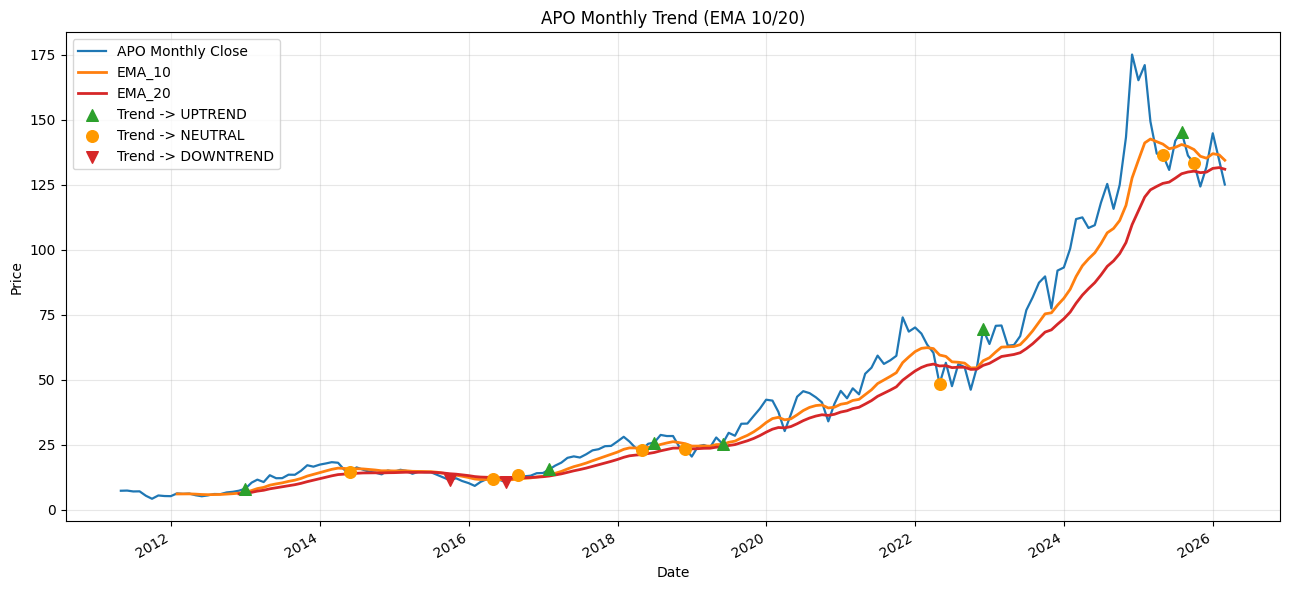

Latest monthly rows:
2025-07-31  Open=141.0200  High=157.2800  Low=139.9300  Close=145.3200  Vol=53125664  EMA_fast=140.4523  EMA_slow=129.2152  Trend=UPTREND
2025-08-31  Open=142.0100  High=151.5800  Low=132.2200  Close=136.2300  Vol=73511363  EMA_fast=139.6846  EMA_slow=129.8833  Trend=UPTREND
2025-09-30  Open=134.2100  High=148.2100  Low=128.9750  Close=133.2700  Vol=72542561  EMA_fast=138.5183  EMA_slow=130.2058  Trend=NEUTRAL
2025-10-31  Open=130.9750  High=133.8000  Low=118.1400  Close=124.3100  Vol=84725888  EMA_fast=135.9350  EMA_slow=129.6443  Trend=NEUTRAL
2025-11-30  Open=124.3100  High=137.0300  Low=122.4900  Close=131.8500  Vol=69567725  EMA_fast=135.1922  EMA_slow=129.8544  Trend=NEUTRAL
2025-12-31  Open=130.1900  High=151.8600  Low=129.0400  Close=144.7600  Vol=62136890  EMA_fast=136.9318  EMA_slow=131.2740  Trend=NEUTRAL
2026-01-31  Open=144.9000  High=153.2900  Low=128.8800  Close=134.5400  Vol=61607314  EMA_fast=136.4970  EMA_slow=131.5850  Trend=NEUTRAL
2026-02-28  O

In [1]:
from pathlib import Path
import csv
from datetime import date
import matplotlib.pyplot as plt

SYMBOL = "APO"
SOURCE_MODE = "auto"  # auto | monthly | daily_aggregate
FAST_EMA_PERIOD = 10
SLOW_EMA_PERIOD = 20
BUFFER_PCT = 0.5
CONFIRM_BARS = 2
START_DATE = None  # Optional YYYY-MM-DD (monthly filter after loading)
MONTHS_TO_PLOT = None  # None = full history (earliest available)


def resolve_data_dir(subdir: str) -> Path:
    candidates = [Path.cwd(), Path.cwd().parent]
    for candidate in candidates:
        target = candidate / "out" / subdir
        if target.exists():
            return target
    raise FileNotFoundError(
        f"Could not find out/{subdir}. Run Jupyter from repo root or notebooks/, and regenerate outputs first."
    )


def parse_float(value: str | None) -> float | None:
    raw = (value or "").strip()
    if not raw:
        return None
    return float(raw)


def parse_int(value: str | None) -> int:
    raw = (value or "").strip()
    if not raw:
        return 0
    return int(float(raw))


def read_daily_rows(csv_path: Path) -> list[dict[str, str]]:
    with csv_path.open("r", encoding="utf-8", newline="") as handle:
        reader = csv.DictReader(handle)
        rows = list(reader)
    if not rows:
        raise ValueError(f"No rows found in {csv_path}")
    rows.sort(key=lambda row: row["Date"])
    return rows


def read_monthly_rows(csv_path: Path) -> list[dict[str, object]]:
    with csv_path.open("r", encoding="utf-8", newline="") as handle:
        reader = csv.DictReader(handle)
        rows = list(reader)
    if not rows:
        raise ValueError(f"No rows found in {csv_path}")

    output: list[dict[str, object]] = []
    for row in sorted(rows, key=lambda item: item["Date"]):
        open_value = parse_float(row.get("Open"))
        high_value = parse_float(row.get("High"))
        low_value = parse_float(row.get("Low"))
        close_value = parse_float(row.get("Close"))
        if close_value is None:
            continue
        output.append(
            {
                "Date": row["Date"],
                "Open": open_value if open_value is not None else close_value,
                "High": high_value if high_value is not None else close_value,
                "Low": low_value if low_value is not None else close_value,
                "Close": close_value,
                "Volume": parse_int(row.get("Volume")),
            }
        )

    if not output:
        raise ValueError(f"Monthly file has no usable rows in {csv_path}")
    return output


def aggregate_to_monthly(daily_rows: list[dict[str, str]]) -> list[dict[str, object]]:
    monthly_rows: list[dict[str, object]] = []
    current_key: tuple[int, int] | None = None
    bucket: dict[str, object] | None = None

    for row in daily_rows:
        row_date = date.fromisoformat(row["Date"])
        month_key = (row_date.year, row_date.month)

        if current_key != month_key:
            if bucket is not None:
                monthly_rows.append(bucket)

            open_value = parse_float(row.get("Open"))
            high_value = parse_float(row.get("High"))
            low_value = parse_float(row.get("Low"))
            close_value = parse_float(row.get("Close"))
            if close_value is None:
                continue
            bucket = {
                "Date": row["Date"],
                "Open": open_value if open_value is not None else close_value,
                "High": high_value if high_value is not None else close_value,
                "Low": low_value if low_value is not None else close_value,
                "Close": close_value,
                "Volume": parse_int(row.get("Volume")),
            }
            current_key = month_key
            continue

        if bucket is None:
            continue

        high_value = parse_float(row.get("High"))
        low_value = parse_float(row.get("Low"))
        close_value = parse_float(row.get("Close"))

        bucket["Date"] = row["Date"]
        if high_value is not None:
            current_high = bucket.get("High")
            if current_high is None or high_value > current_high:
                bucket["High"] = high_value
        if low_value is not None:
            current_low = bucket.get("Low")
            if current_low is None or low_value < current_low:
                bucket["Low"] = low_value
        if close_value is not None:
            bucket["Close"] = close_value
        bucket["Volume"] = int(bucket.get("Volume", 0)) + parse_int(row.get("Volume"))

    if bucket is not None:
        monthly_rows.append(bucket)

    return monthly_rows


def compute_ema(values: list[float], period: int) -> list[float | None]:
    output: list[float | None] = [None] * len(values)
    if period <= 0 or len(values) < period:
        return output

    smoothing = 2.0 / (period + 1.0)
    seed = sum(values[:period]) / period
    output[period - 1] = seed

    prev = seed
    for idx in range(period, len(values)):
        current = (values[idx] - prev) * smoothing + prev
        output[idx] = current
        prev = current

    return output


def classify_candidate_trend(
    close_value: float | None,
    fast_ema: float | None,
    slow_ema: float | None,
    buffer_ratio: float,
) -> str:
    if close_value is None or fast_ema is None or slow_ema is None:
        return "NEUTRAL"

    uptrend_price = close_value > fast_ema * (1.0 + buffer_ratio)
    uptrend_stack = fast_ema > slow_ema * (1.0 + buffer_ratio)
    downtrend_price = close_value < fast_ema * (1.0 - buffer_ratio)
    downtrend_stack = fast_ema < slow_ema * (1.0 - buffer_ratio)

    if uptrend_price and uptrend_stack:
        return "UPTREND"
    if downtrend_price and downtrend_stack:
        return "DOWNTREND"
    return "NEUTRAL"


def trend_color(trend: str) -> str:
    if trend == "UPTREND":
        return "GREEN"
    if trend == "DOWNTREND":
        return "RED"
    return "ORANGE"


def apply_confirmed_trend(
    monthly_rows: list[dict[str, object]],
    fast_ema: list[float | None],
    slow_ema: list[float | None],
    buffer_ratio: float,
    confirm_bars: int,
) -> list[dict[str, object]]:
    output: list[dict[str, object]] = []
    current_trend = "NEUTRAL"
    pending_trend: str | None = None
    pending_count = 0

    for idx, row in enumerate(monthly_rows):
        close_value = row.get("Close")
        close_num = float(close_value) if close_value is not None else None
        candidate = classify_candidate_trend(
            close_value=close_num,
            fast_ema=fast_ema[idx],
            slow_ema=slow_ema[idx],
            buffer_ratio=buffer_ratio,
        )

        if candidate == current_trend:
            pending_trend = None
            pending_count = 0
        else:
            if candidate == pending_trend:
                pending_count += 1
            else:
                pending_trend = candidate
                pending_count = 1

            if pending_trend is not None and pending_count >= confirm_bars:
                current_trend = pending_trend
                pending_trend = None
                pending_count = 0

        enriched = dict(row)
        enriched["EMA_Fast"] = fast_ema[idx]
        enriched["EMA_Slow"] = slow_ema[idx]
        enriched["TrendCandidate"] = candidate
        enriched["Trend"] = current_trend
        enriched["TrendColor"] = trend_color(current_trend)
        output.append(enriched)

    return output


if FAST_EMA_PERIOD <= 0 or SLOW_EMA_PERIOD <= 0:
    raise ValueError("EMA periods must be > 0")
if FAST_EMA_PERIOD >= SLOW_EMA_PERIOD:
    raise ValueError("FAST_EMA_PERIOD should be smaller than SLOW_EMA_PERIOD")
if BUFFER_PCT < 0:
    raise ValueError("BUFFER_PCT must be >= 0")
if CONFIRM_BARS <= 0:
    raise ValueError("CONFIRM_BARS must be > 0")
if SOURCE_MODE not in {"auto", "monthly", "daily_aggregate"}:
    raise ValueError("SOURCE_MODE must be one of: auto, monthly, daily_aggregate")

monthly_rows: list[dict[str, object]] = []
source_description = ""

if SOURCE_MODE in {"auto", "monthly"}:
    try:
        monthly_dir = resolve_data_dir("monthly")
    except FileNotFoundError:
        monthly_dir = None

    if monthly_dir is not None:
        monthly_csv = monthly_dir / f"{SYMBOL}.csv"
        if monthly_csv.exists():
            monthly_rows = read_monthly_rows(monthly_csv)
            source_description = f"monthly file: {Path("out") / "monthly" / f"{SYMBOL}.csv"}"
        elif SOURCE_MODE == "monthly":
            raise FileNotFoundError(
                f"Missing file: {monthly_csv}. Run: python3 fetch_stooq_ohlc.py --interval m"
            )
    elif SOURCE_MODE == "monthly":
        raise FileNotFoundError(
            "Missing directory: out/monthly. Run: python3 fetch_stooq_ohlc.py --interval m"
        )

if not monthly_rows:
    daily_dir = resolve_data_dir("daily")
    daily_csv = daily_dir / f"{SYMBOL}.csv"
    if not daily_csv.exists():
        raise FileNotFoundError(
            f"Missing file: {daily_csv}. Run: python3 fetch_stooq_ohlc.py"
        )
    daily_rows = read_daily_rows(daily_csv)
    monthly_rows = aggregate_to_monthly(daily_rows)
    source_description = f"daily aggregate from: {Path("out") / "daily" / f"{SYMBOL}.csv"}"

if START_DATE:
    start_date = date.fromisoformat(START_DATE)
    monthly_rows = [row for row in monthly_rows if date.fromisoformat(str(row["Date"])) >= start_date]

if not monthly_rows:
    raise ValueError("No monthly rows available after filtering")

monthly_closes: list[float] = []
for row in monthly_rows:
    close_value = row.get("Close")
    if close_value is None:
        raise ValueError(f"Monthly row has missing Close value: {row}")
    monthly_closes.append(float(close_value))

fast_ema = compute_ema(monthly_closes, FAST_EMA_PERIOD)
slow_ema = compute_ema(monthly_closes, SLOW_EMA_PERIOD)
buffer_ratio = BUFFER_PCT / 100.0
trend_rows = apply_confirmed_trend(
    monthly_rows=monthly_rows,
    fast_ema=fast_ema,
    slow_ema=slow_ema,
    buffer_ratio=buffer_ratio,
    confirm_bars=CONFIRM_BARS,
)

if MONTHS_TO_PLOT is None:
    start_idx = 0
else:
    start_idx = max(0, len(trend_rows) - MONTHS_TO_PLOT)

plot_rows = trend_rows[start_idx:]
plot_dates = [date.fromisoformat(str(row["Date"])) for row in plot_rows]
plot_close = [float(row["Close"]) for row in plot_rows]
plot_fast = [row.get("EMA_Fast") for row in plot_rows]
plot_slow = [row.get("EMA_Slow") for row in plot_rows]

trend_changes: list[tuple[int, str]] = []
for idx in range(1, len(plot_rows)):
    prev_trend = str(plot_rows[idx - 1]["Trend"])
    curr_trend = str(plot_rows[idx]["Trend"])
    if curr_trend != prev_trend:
        trend_changes.append((idx, curr_trend))

print(f"Source: {source_description}")
print(f"Loaded {len(trend_rows)} monthly rows for {SYMBOL}.")
print(f"Monthly range: {trend_rows[0]['Date']} to {trend_rows[-1]['Date']}")
print(f"Plot window months: {len(plot_rows)}")

fig, ax = plt.subplots(1, 1, figsize=(13, 6))
ax.plot(plot_dates, plot_close, label=f"{SYMBOL} Monthly Close", color="#1f77b4", linewidth=1.6)
ax.plot(plot_dates, plot_fast, label=f"EMA_{FAST_EMA_PERIOD}", color="#ff7f0e", linewidth=2.0)
ax.plot(plot_dates, plot_slow, label=f"EMA_{SLOW_EMA_PERIOD}", color="#d62728", linewidth=2.0)

trend_style = {
    "UPTREND": {"color": "#2ca02c", "marker": "^", "label": "Trend -> UPTREND"},
    "DOWNTREND": {"color": "#d62728", "marker": "v", "label": "Trend -> DOWNTREND"},
    "NEUTRAL": {"color": "#ff9900", "marker": "o", "label": "Trend -> NEUTRAL"},
}
legend_seen: set[str] = set()

for idx, trend in trend_changes:
    style = trend_style.get(trend)
    if style is None:
        continue
    marker_label = style["label"] if trend not in legend_seen else "_nolegend_"
    legend_seen.add(trend)
    ax.scatter(
        [plot_dates[idx]],
        [plot_close[idx]],
        s=70,
        marker=style["marker"],
        color=style["color"],
        label=marker_label,
        zorder=6,
    )

ax.set_title(f"{SYMBOL} Monthly Trend (EMA {FAST_EMA_PERIOD}/{SLOW_EMA_PERIOD})")
ax.set_xlabel("Date")
ax.set_ylabel("Price")
ax.grid(alpha=0.3)
ax.legend(loc="best")
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

print("Latest monthly rows:")
for row in trend_rows[-8:]:
    ema_fast_text = "" if row["EMA_Fast"] is None else f"{float(row['EMA_Fast']):.4f}"
    ema_slow_text = "" if row["EMA_Slow"] is None else f"{float(row['EMA_Slow']):.4f}"
    print(
        f"{row['Date']}  Open={float(row['Open']):.4f}  High={float(row['High']):.4f}  "
        f"Low={float(row['Low']):.4f}  Close={float(row['Close']):.4f}  Vol={int(row['Volume'])}  "
        f"EMA_fast={ema_fast_text}  EMA_slow={ema_slow_text}  Trend={row['Trend']}"
    )


